This program permits the testing of various forecasting techniques against the same datasets

In [1]:
# load packages
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import random
import datetime
import statsmodels as sm
import sklearn
import sklearn.preprocessing

In [2]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [140]:
plt.style.use('ggplot')

In [141]:
# read in the CSV file with 30,490 observations
largefile = pd.read_csv('sales_train_validation.csv')

In [4]:
# read in the CSV file with calendar dates and holiday information
calendar_long = pd.read_csv('calendar.csv')
calendar_long

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
# reduce the number of rows to just that found in the smaller train dataset
calendar_short = pd.read_csv('calendar.csv')
calendar_short.drop(index=[*range(1913, 1969, 1)], axis = 0, inplace=True)
calendar_short

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [6]:
# convert the date into python datetime
calendar_short['date'] = pd.to_datetime(calendar_short['date'])
# calendar_short['date'].info()

In [7]:
# select a subset of 1000 random observations
smallerfile = largefile.sample(n=1000, random_state = 365)
smallerfile

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
9694,HOBBIES_2_132_CA_4_validation,HOBBIES_2_132,HOBBIES_2,HOBBIES,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14813,FOODS_3_393_TX_1_validation,FOODS_3_393,FOODS_3,FOODS,TX_1,TX,0,0,0,0,...,2,7,8,10,13,3,6,7,8,11
10278,HOUSEHOLD_2_035_CA_4_validation,HOUSEHOLD_2_035,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
13320,HOUSEHOLD_2_028_TX_1_validation,HOUSEHOLD_2_028,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX,0,2,0,1,...,1,0,0,0,0,0,0,0,1,0
20031,FOODS_1_128_TX_3_validation,FOODS_1_128,FOODS_1,FOODS,TX_3,TX,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19097,HOUSEHOLD_1_244_TX_3_validation,HOUSEHOLD_1_244,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,0,0,0,0,...,0,0,1,1,1,1,2,0,0,0
11003,FOODS_2_029_CA_4_validation,FOODS_2_029,FOODS_2,FOODS,CA_4,CA,2,5,0,5,...,1,0,2,4,2,1,3,1,0,1
13342,HOUSEHOLD_2_050_TX_1_validation,HOUSEHOLD_2_050,HOUSEHOLD_2,HOUSEHOLD,TX_1,TX,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
13844,FOODS_1_038_TX_1_validation,FOODS_1_038,FOODS_1,FOODS,TX_1,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
smallerfile['sum_demand'] = smallerfile.sum(axis=1, numeric_only=True)/1913
smallerfile = smallerfile.sort_values(by='sum_demand', ascending=False)
smallerfile

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_demand
30251,FOODS_3_586_WI_3_validation,FOODS_3_586,FOODS_3,FOODS,WI_3,WI,61,67,35,66,...,48,40,35,22,25,31,35,47,44,44.997386
26842,FOODS_3_226_WI_2_validation,FOODS_3_226,FOODS_3,FOODS,WI_2,WI,46,30,21,38,...,56,67,40,31,40,50,48,43,38,36.573968
9035,FOODS_3_714_CA_3_validation,FOODS_3_714,FOODS_3,FOODS,CA_3,CA,18,17,10,15,...,35,57,24,25,33,23,20,42,40,27.126503
2811,FOODS_3_587_CA_1_validation,FOODS_3_587,FOODS_3,FOODS,CA_1,CA,50,121,67,80,...,27,36,16,10,15,10,21,24,26,27.034501
26578,FOODS_2_360_WI_2_validation,FOODS_2_360,FOODS_2,FOODS,WI_2,WI,0,0,0,0,...,51,35,42,43,34,68,51,46,30,25.113957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10082,HOUSEHOLD_1_378_CA_4_validation,HOUSEHOLD_1_378,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.019864
14600,FOODS_3_180_TX_1_validation,FOODS_3_180,FOODS_3,FOODS,TX_1,TX,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.016728
26751,FOODS_3_135_WI_2_validation,FOODS_3_135,FOODS_3,FOODS,WI_2,WI,0,0,0,0,...,1,0,0,0,0,0,0,2,0,0.016205
21736,HOBBIES_1_402_WI_1_validation,HOBBIES_1_402,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.014637


In [9]:
# select a single SKU
single_sku = smallerfile.loc[smallerfile.index == 9035]
single_sku

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,sum_demand
9035,FOODS_3_714_CA_3_validation,FOODS_3_714,FOODS_3,FOODS,CA_3,CA,18,17,10,15,...,35,57,24,25,33,23,20,42,40,27.126503


In [10]:
# transpose the data frame
single_sku = single_sku.transpose()

In [11]:
single_sku = single_sku.reset_index()
single_sku

,index,9035
0,id,FOODS_3_714_CA_3_validation
1,item_id,FOODS_3_714
2,dept_id,FOODS_3
3,cat_id,FOODS
4,store_id,CA_3
...,...,...
1915,d_1910,23
1916,d_1911,20
1917,d_1912,42
1918,d_1913,40


In [12]:
# just save the demand rows in the datafram

single_sku.drop(index=[*range(0,6,1)], axis = 1, inplace= True)
single_sku

,index,9035
6,d_1,18
7,d_2,17
8,d_3,10
9,d_4,15
10,d_5,7
...,...,...
1915,d_1910,23
1916,d_1911,20
1917,d_1912,42
1918,d_1913,40


In [13]:
single_sku.columns = ['Day', 'Demand']
single_sku = single_sku.reset_index(drop=True)
single_sku

,Day,Demand
0,d_1,18
1,d_2,17
2,d_3,10
3,d_4,15
4,d_5,7
...,...,...
1909,d_1910,23
1910,d_1911,20
1911,d_1912,42
1912,d_1913,40


In [14]:
# creating a naive forecast
# https://discuss.datasciencedojo.com/t/how-to-create-lags-and-leads-of-a-column/1023/2
single_sku['Naive'] = single_sku['Demand'].shift(1)
single_sku

,Day,Demand,Naive
0,d_1,18,None
1,d_2,17,18
2,d_3,10,17
3,d_4,15,10
4,d_5,7,15
...,...,...,...
1909,d_1910,23,33
1910,d_1911,20,23
1911,d_1912,42,20
1912,d_1913,40,42


In [15]:
# set up the dates for the data in the data frame
num_days = len(single_sku)
start_date = datetime.datetime(2011, 1, 29)
dates = [start_date + datetime.timedelta(days=idx) for idx in range(num_days)]
single_sku['date'] = dates
single_sku

,Day,Demand,Naive,date
0,d_1,18,None,2011-01-29
1,d_2,17,18,2011-01-30
2,d_3,10,17,2011-01-31
3,d_4,15,10,2011-02-01
4,d_5,7,15,2011-02-02
...,...,...,...,...
1909,d_1910,23,33,2016-04-21
1910,d_1911,20,23,2016-04-22
1911,d_1912,42,20,2016-04-23
1912,d_1913,40,42,2016-04-24


In [16]:
calendar_short

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,2016-04-23,11613,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [17]:
single_sku['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1914 entries, 0 to 1913
Series name: date
Non-Null Count  Dtype         
--------------  -----         
1914 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 15.1 KB


In [18]:
calendar_short['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1913 entries, 0 to 1912
Series name: date
Non-Null Count  Dtype         
--------------  -----         
1913 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 15.1 KB


In [19]:
merged = single_sku.merge(calendar_short, on='date', how='left', indicator = True)
merged

,Day,Demand,Naive,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,_merge
0,d_1,18,None,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1,d_2,17,18,2011-01-30,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2,d_3,10,17,2011-01-31,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
3,d_4,15,10,2011-02-01,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,both
4,d_5,7,15,2011-02-02,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,d_1910,23,33,2016-04-21,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1910,d_1911,20,23,2016-04-22,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1911,d_1912,42,20,2016-04-23,11613.0,Saturday,1.0,4.0,2016.0,d_1912,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1912,d_1913,40,42,2016-04-24,11613.0,Sunday,2.0,4.0,2016.0,d_1913,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both


In [20]:
merged = merged.drop(1913, axis='index')

In [21]:
merged

,Day,Demand,Naive,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,_merge
0,d_1,18,None,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1,d_2,17,18,2011-01-30,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2,d_3,10,17,2011-01-31,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
3,d_4,15,10,2011-02-01,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,both
4,d_5,7,15,2011-02-02,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,33,25,2016-04-20,11612.0,Wednesday,5.0,4.0,2016.0,d_1909,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1909,d_1910,23,33,2016-04-21,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1910,d_1911,20,23,2016-04-22,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
1911,d_1912,42,20,2016-04-23,11613.0,Saturday,1.0,4.0,2016.0,d_1912,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both


In [22]:
# calculate forecast accuracy metrics
errors = single_sku['Demand']-single_sku['Naive']
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
# mape = np.mean(np.abs(errors / single_sku['Demand'])) * 100
# smape = np.mean(2 * np.abs(errors)) /(np.abs(single_sku['Demand'] + np.abs(single_sku['Naive'])))

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
# errors

MAE: 8.39
MSE: 119.69
RMSE: 10.94


In [23]:
merged = merged.set_index('date')

In [24]:
merged

,Day,Demand,Naive,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,_merge
date,,,,,,,,,,,,,,,,,
2011-01-29,d_1,18,None,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2011-01-30,d_2,17,18,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2011-01-31,d_3,10,17,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2011-02-01,d_4,15,10,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,both
2011-02-02,d_5,7,15,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,d_1909,33,25,11612.0,Wednesday,5.0,4.0,2016.0,d_1909,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2016-04-21,d_1910,23,33,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both
2016-04-22,d_1911,20,23,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both


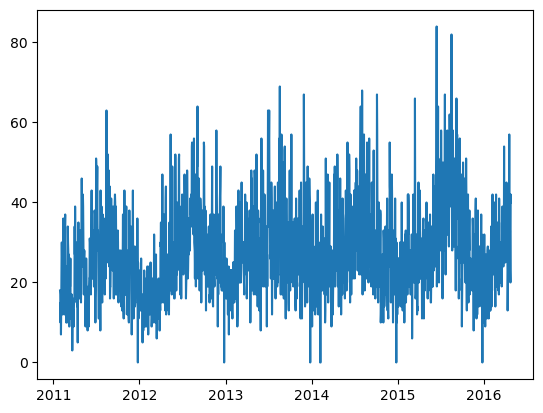

In [25]:
# create a simple demand chart
plt.plot(merged.index, merged['Demand'])

(array([14610., 14975., 15340., 15706., 16071., 16436., 16801.]),
 [Text(14610.0, 0, '2010'),
  Text(14975.0, 0, '2011'),
  Text(15340.0, 0, '2012'),
  Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016')])

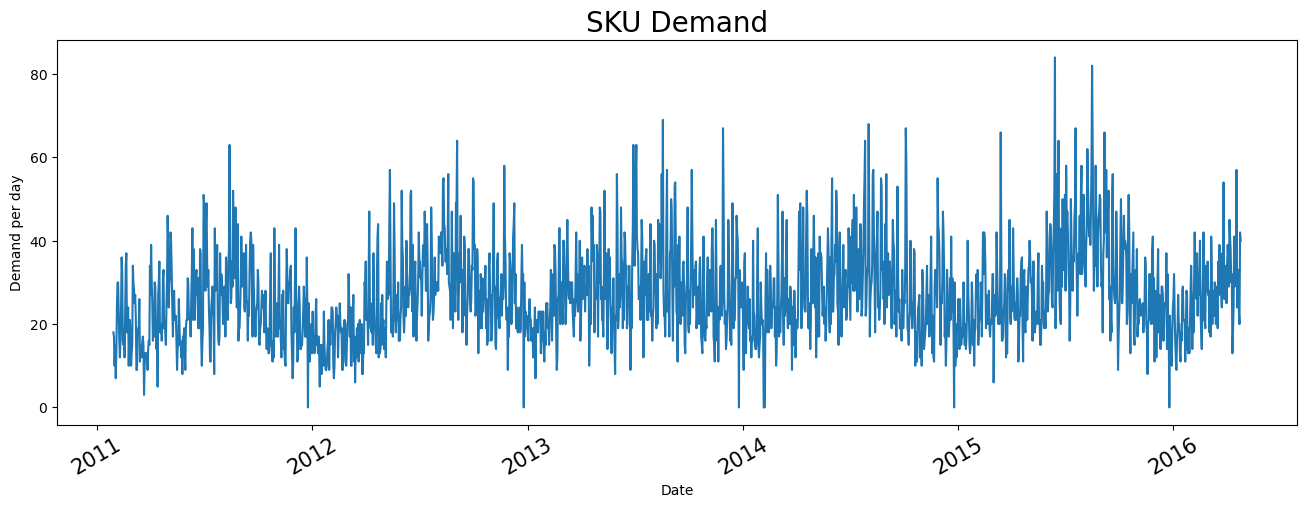

In [26]:
# creating a more sophisticated chart
fig = plt.subplots(figsize=(16,5))
plt.plot(merged.index, merged['Demand'])
plt.title('SKU Demand', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Demand per day')
plt.xticks(rotation=30, fontsize=15)

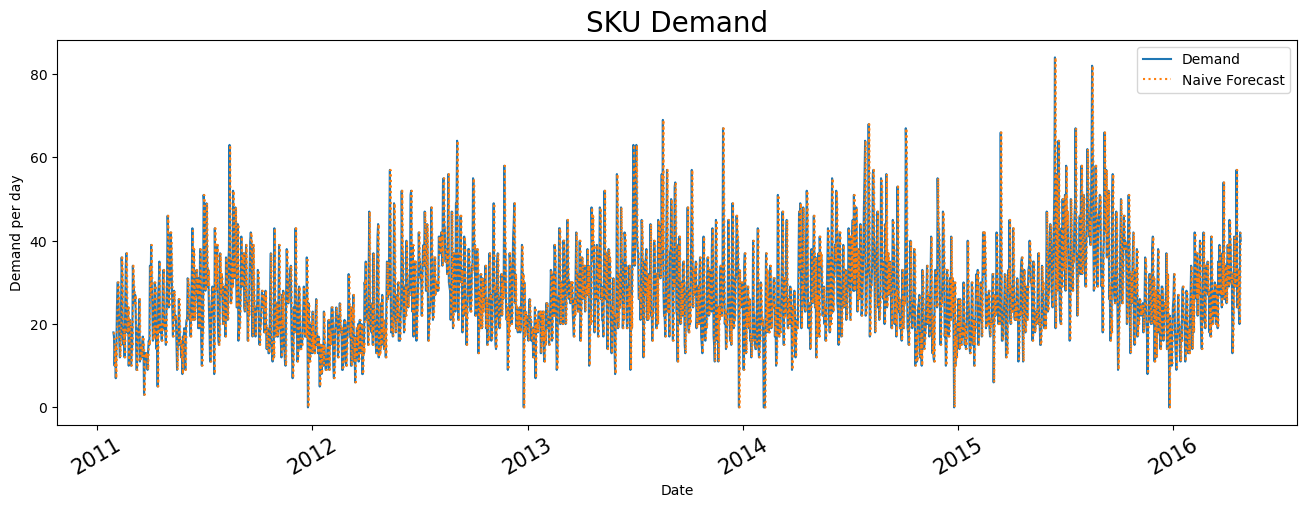

In [27]:
# creating a more sophisticated chart
fig = plt.subplots(figsize=(16,5))
plt.plot(merged.index, merged['Demand'], label = 'Demand', linestyle='-')
plt.plot(merged.index, merged['Naive'], label = 'Naive Forecast', linestyle=':')
plt.title('SKU Demand', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Demand per day')
plt.xticks(rotation=30, fontsize=15)
plt.legend()
plt.show()

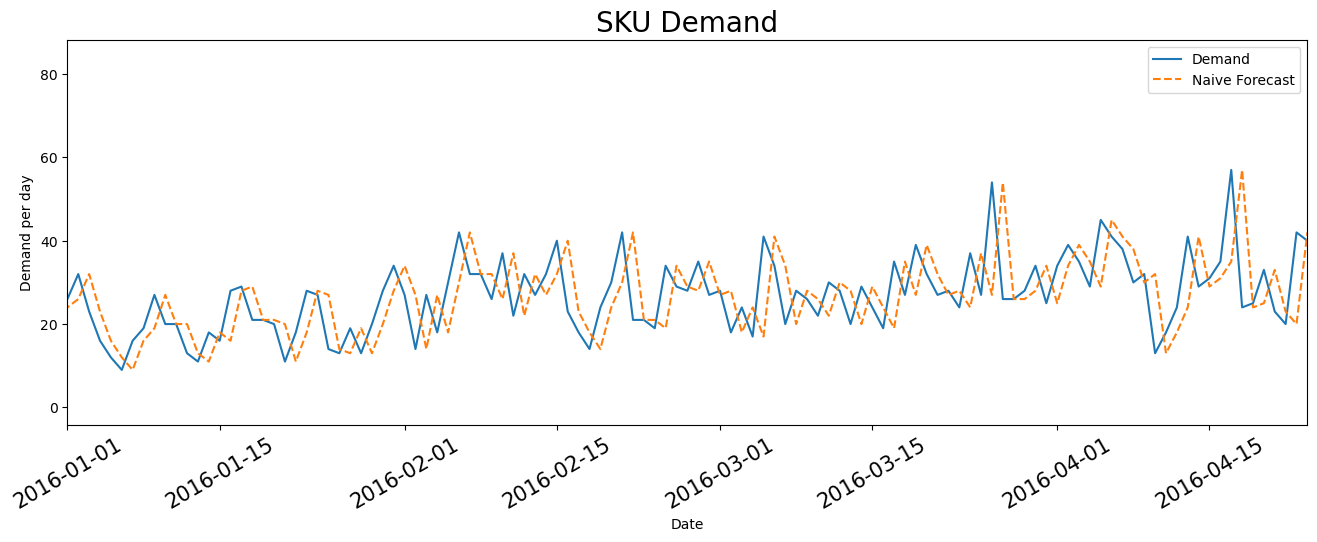

In [28]:
# creating a shorter view of the more sophisticated chart
fig = plt.subplots(figsize=(16,5))
plt.plot(merged.index, merged['Demand'], label = 'Demand', linestyle='-')
plt.plot(merged.index, merged['Naive'], label = 'Naive Forecast', linestyle='--')
plt.title('SKU Demand', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Demand per day')
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2016-01-01'),pd.Timestamp('2016-04-24'))
plt.legend()
plt.show()

In [29]:
errors

0             NaN
1              -1
2              -7
3               5
4              -8
          ...    
1909          -10
1910           -3
1911           22
1912           -2
1913   -12.873497
Length: 1914, dtype: object

In [30]:
errors = errors.drop(1913)

In [31]:
merged['errors'] = errors.values
merged

,Day,Demand,Naive,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,_merge,errors
date,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,18,None,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,NaN
2011-01-30,d_2,17,18,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-1
2011-01-31,d_3,10,17,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-7
2011-02-01,d_4,15,10,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,both,5
2011-02-02,d_5,7,15,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,both,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,d_1909,33,25,11612.0,Wednesday,5.0,4.0,2016.0,d_1909,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,8
2016-04-21,d_1910,23,33,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-10
2016-04-22,d_1911,20,23,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-3


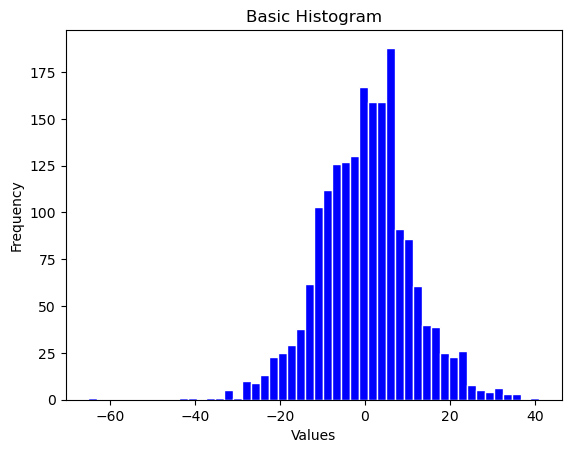

In [32]:
# Plotting a basic histogram
plt.hist(merged['errors'], bins=50, color='blue', edgecolor='white')
 
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
 
# Display the plot
plt.show()

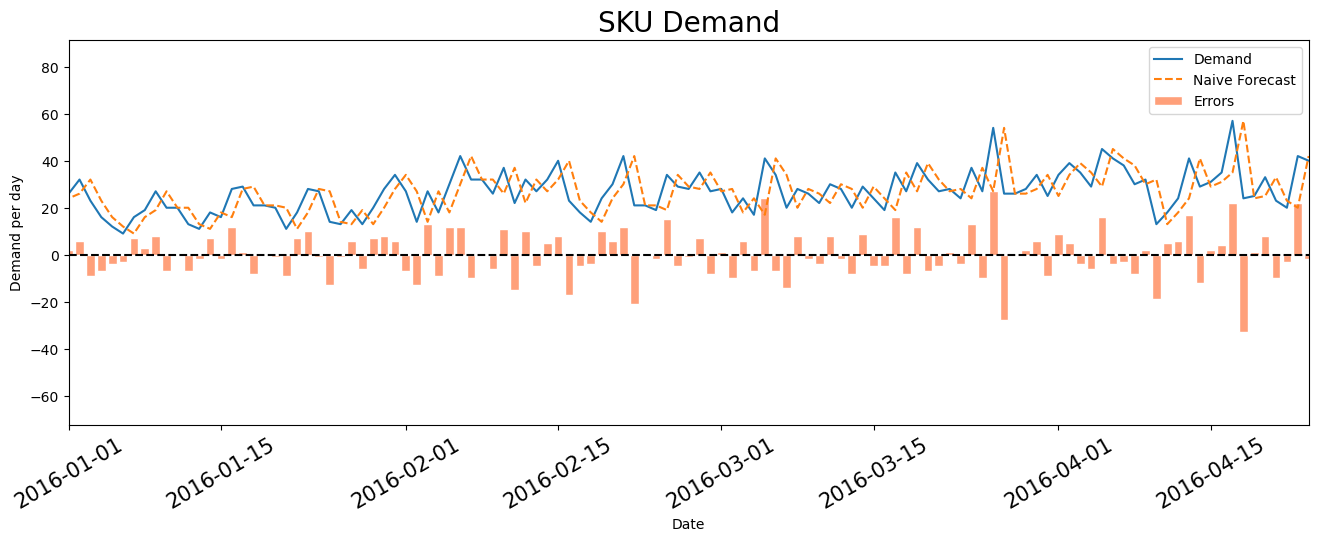

In [33]:
# creating a more sophisticated chart with the demand, forecast and error
fig = plt.subplots(figsize=(16,5))
plt.plot(merged.index, merged['Demand'], label = 'Demand', linestyle='-')
plt.plot(merged.index, merged['Naive'], label = 'Naive Forecast', linestyle='--')
plt.bar(merged.index, merged['errors'], label = 'Errors', color="lightsalmon", edgecolor="white")
plt.axhline(y = 0.0, color = 'black', linestyle = '--') 
plt.title('SKU Demand', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Demand per day')
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2016-01-01'),pd.Timestamp('2016-04-24'))
plt.legend()
plt.show()

In [34]:
merged

,Day,Demand,Naive,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,_merge,errors
date,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,18,None,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,NaN
2011-01-30,d_2,17,18,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-1
2011-01-31,d_3,10,17,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-7
2011-02-01,d_4,15,10,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,both,5
2011-02-02,d_5,7,15,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,both,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,d_1909,33,25,11612.0,Wednesday,5.0,4.0,2016.0,d_1909,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,8
2016-04-21,d_1910,23,33,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-10
2016-04-22,d_1911,20,23,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,NaN,NaN,NaN,0.0,0.0,0.0,both,-3


In [35]:
print(merged['event_name_1'].value_counts())

event_name_1
SuperBowl              6
PresidentsDay          6
LentStart              6
LentWeek2              6
StPatricksDay          6
Purim End              6
ValentinesDay          6
Thanksgiving           5
Halloween              5
EidAlAdha              5
VeteransDay            5
NewYear                5
Christmas              5
Chanukah End           5
LaborDay               5
OrthodoxChristmas      5
MartinLutherKingDay    5
ColumbusDay            5
IndependenceDay        5
Eid al-Fitr            5
Ramadan starts         5
NBAFinalsEnd           5
NBAFinalsStart         5
MemorialDay            5
Mother's day           5
Pesach End             5
Easter                 5
Father's day           4
Cinco De Mayo          4
OrthodoxEaster         4
Name: count, dtype: int64


In [36]:
print(merged['event_name_2'].value_counts())

event_name_2
Easter            1
Cinco De Mayo     1
OrthodoxEaster    1
Father's day      1
Name: count, dtype: int64


In [37]:
for col in merged.columns:
    print(col)

Day
Demand
Naive
wm_yr_wk
weekday
wday
month
year
d
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
_merge
errors


In [38]:
print(merged['event_type_1'].value_counts())

event_type_1
Religious    52
National     51
Cultural     35
Sporting     16
Name: count, dtype: int64


In [39]:
print(merged['event_type_2'].value_counts())

event_type_2
Cultural     3
Religious    1
Name: count, dtype: int64


In [40]:
# set up the one hot encoder ... the set_output will result in a data frame instead of an array
ohe=OneHotEncoder(handle_unknown = 'ignore', sparse_output=False).set_output(transform='pandas')

In [41]:
# run the one hot encoder against the data frame targeted columns
one_hot_encoded_data = ohe.fit_transform(merged[['event_name_1', 'event_name_2']])

In [42]:
one_hot_encoded_data

,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,...,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_name_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2016-04-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2016-04-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [43]:
# test to make sure the one hot encoding worked
print(one_hot_encoded_data['event_name_1_Christmas'].value_counts())

event_name_1_Christmas
0.0    1908
1.0       5
Name: count, dtype: int64


In [44]:
# left join the one hot encoded data with the merged file
result = merged.merge(one_hot_encoded_data, how='left', on='date')
result

,Day,Demand,Naive,wm_yr_wk,weekday,wday,month,year,d,event_name_1,...,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_name_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,18,None,11101.0,Saturday,1.0,1.0,2011.0,d_1,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-01-30,d_2,17,18,11101.0,Sunday,2.0,1.0,2011.0,d_2,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-01-31,d_3,10,17,11101.0,Monday,3.0,1.0,2011.0,d_3,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-02-01,d_4,15,10,11101.0,Tuesday,4.0,2.0,2011.0,d_4,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2011-02-02,d_5,7,15,11101.0,Wednesday,5.0,2.0,2011.0,d_5,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,d_1909,33,25,11612.0,Wednesday,5.0,4.0,2016.0,d_1909,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2016-04-21,d_1910,23,33,11612.0,Thursday,6.0,4.0,2016.0,d_1910,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2016-04-22,d_1911,20,23,11612.0,Friday,7.0,4.0,2016.0,d_1911,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


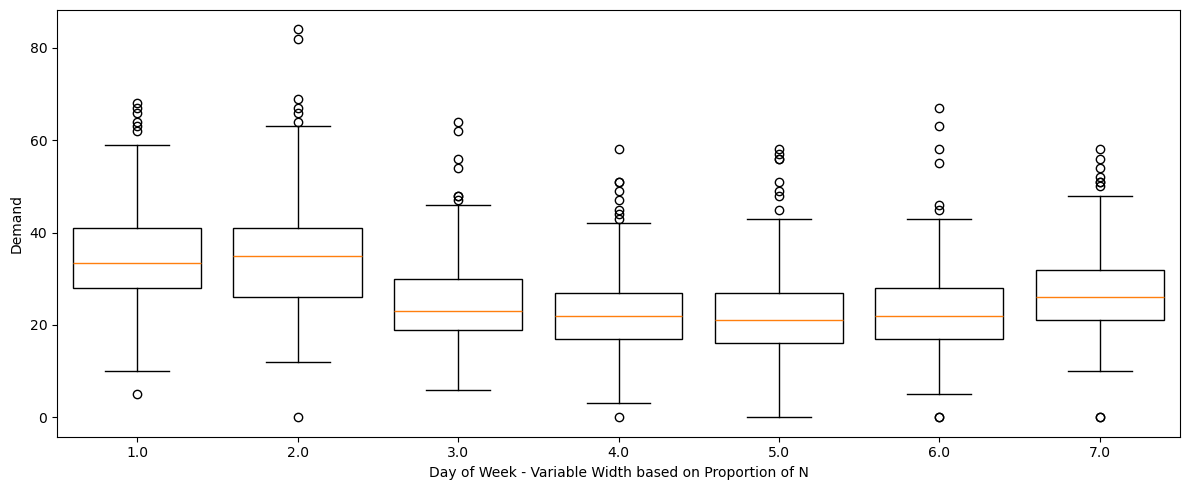

In [45]:
# adapted from https://stackoverflow.com/questions/63792528/boxplot-custom-width-in-seaborn
fig, ax1 = plt.subplots(ncols=1, figsize=(12, 5))
bins, groups = zip(*result.groupby('wday')['Demand'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            patch_artist=True, boxprops={'facecolor': 'white'})
ax1.set_xticklabels(bins)
ax1.set_xlabel('Day of Week - Variable Width based on Proportion of N')
ax1.set_ylabel('Demand')
plt.tight_layout()
plt.show()

In [46]:
# create a boxplot to illustrate differences
# illustrate how to get the means
bp = ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
means = [mean.get_ydata() for mean in bp["means"]]
means = pd.DataFrame(means)
means.columns = ['means']
means.means = round(means.means,1)
means

,means
0,34.7
1,34.7
2,24.6
3,22.6
4,22.5
5,23.3
6,27.5


In [47]:
# calculate the variable widths for the boxplot
df2 = result.groupby(['wday']).size()
largest = df2.max()
maxwidth = 0.8
df2 = df2.to_frame(name='count')
df2 = df2.reset_index()
df2['width'] = maxwidth * df2['count'] / largest
width = df2['width']
width

0    0.80000
1    0.80000
2    0.79708
3    0.79708
4    0.79708
5    0.79708
6    0.79708
Name: width, dtype: float64

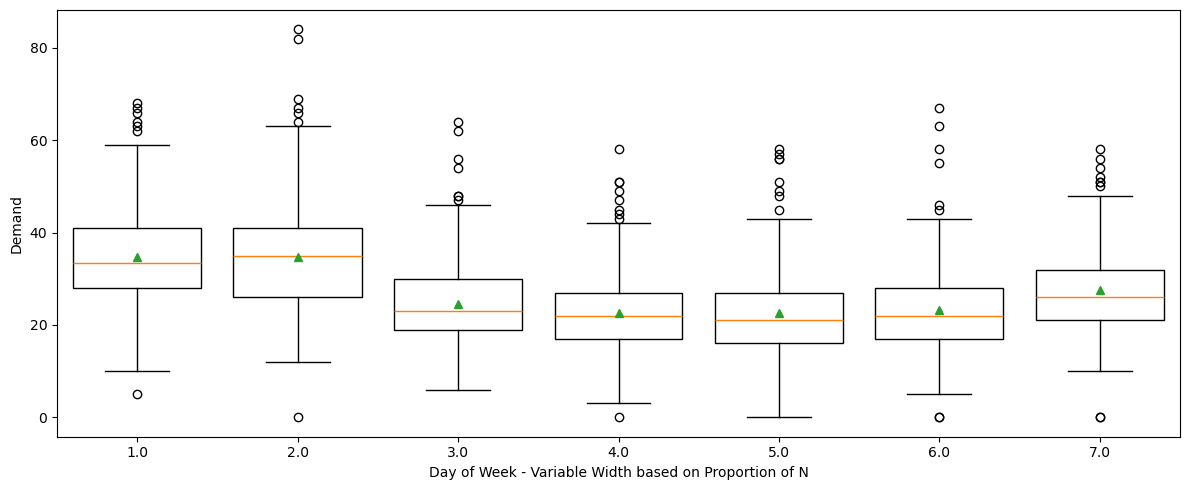

In [48]:
# add the means labels to the boxplots
# https://stackoverflow.com/questions/58066009/how-to-display-numeric-mean-and-std-values-next-to-a-box-plot-in-a-series-of-box

fig, ax1 = plt.subplots(ncols=1, figsize=(12, 5))
bins, groups = zip(*result.groupby('wday')['Demand'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
ax1.set_xticklabels(bins)
ax1.set_xlabel('Day of Week - Variable Width based on Proportion of N')
ax1.set_ylabel('Demand')
plt.tight_layout()
plt.show()

In [49]:
# illustrate how to get the means
bp = ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
means = [mean.get_ydata() for mean in bp["means"]]
means = pd.DataFrame(means)
means.columns = ['means']
means.means = round(means.means,1)
means

,means
0,34.7
1,34.7
2,24.6
3,22.6
4,22.5
5,23.3
6,27.5


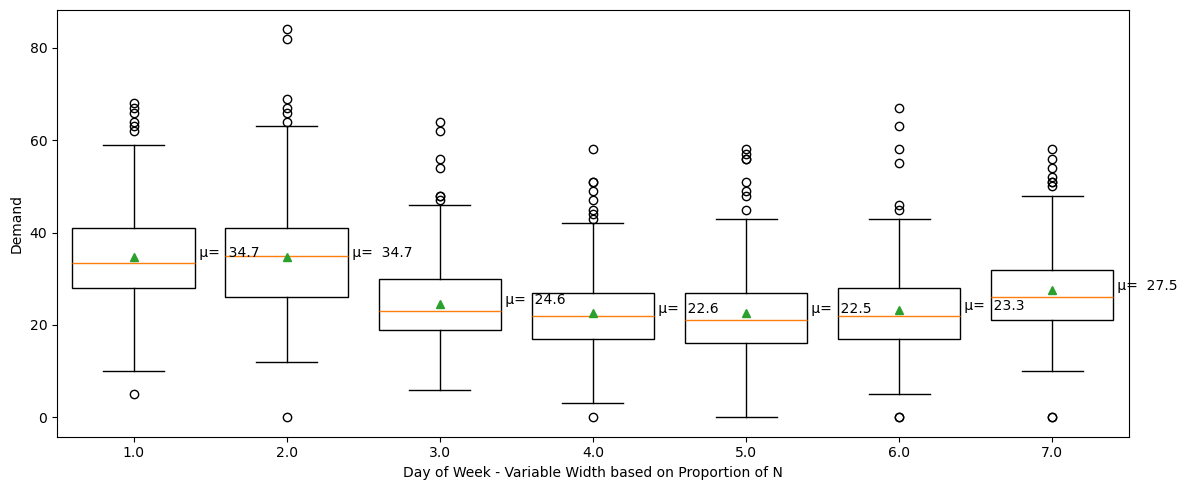

In [50]:
# add the means labels to the boxplots
# https://stackoverflow.com/questions/58066009/how-to-display-numeric-mean-and-std-values-next-to-a-box-plot-in-a-series-of-box

fig, ax1 = plt.subplots(ncols=1, figsize=(12, 5))
bins, groups = zip(*result.groupby('wday')['Demand'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
means = [mean.get_ydata() for mean in bp["means"]]
means = pd.DataFrame(means)
means.columns = ['means']
means.means = round(means.means,1)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    x=x
    y=means.means[i]
    text = ' μ=  ' + str(means.means[i])
    ax1.annotate(text, xy=(x, y))

ax1.set_xticklabels(bins)
ax1.set_xlabel('Day of Week - Variable Width based on Proportion of N')
ax1.set_ylabel('Demand')
plt.tight_layout()
plt.show()

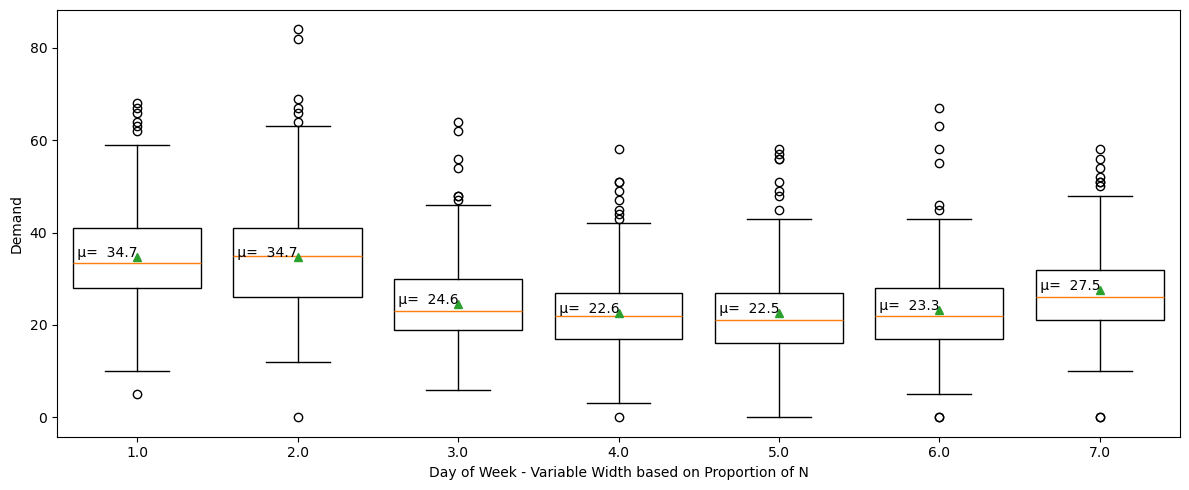

In [97]:
# add the means labels to the boxplots
# https://stackoverflow.com/questions/58066009/how-to-display-numeric-mean-and-std-values-next-to-a-box-plot-in-a-series-of-box

fig, ax1 = plt.subplots(ncols=1, figsize=(12, 5))
bins, groups = zip(*result.groupby('wday')['Demand'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
means = [mean.get_ydata() for mean in bp["means"]]
means = pd.DataFrame(means)
means.columns = ['means']
means.means = round(means.means,1)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[0]
    x=x
    y=means.means[i]
    text = ' μ=  ' + str(means.means[i])
    ax1.annotate(text, xy=(x, y))

ax1.set_xticklabels(bins)
ax1.set_xlabel('Day of Week - Variable Width based on Proportion of N')
ax1.set_ylabel('Demand')
plt.tight_layout()
plt.show()



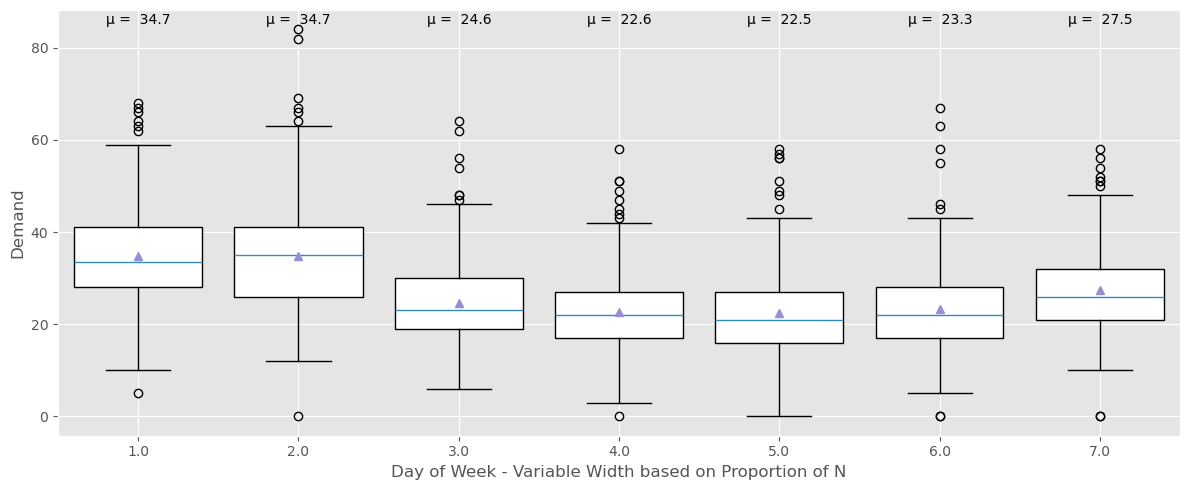

In [143]:
# add the means labels to the boxplots
# https://stackoverflow.com/questions/58066009/how-to-display-numeric-mean-and-std-values-next-to-a-box-plot-in-a-series-of-box

fig, ax1 = plt.subplots(ncols=1, figsize=(12, 5))
bins, groups = zip(*result.groupby('wday')['Demand'])
lengths = np.array([len(group) for group in groups])
max_width = 0.8
ax1.boxplot(groups, widths=max_width * lengths / lengths.max(),
            showmeans=True,
            patch_artist=True, boxprops={'facecolor': 'white'})
means = [mean.get_ydata() for mean in bp["means"]]
means = pd.DataFrame(means)
means.columns = ['means']
means.means = round(means.means,1)
yvalue = ax1.get_ylim()[1]
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[0]
    x1, y = line.get_xydata()[0]
    x2, y = line.get_xydata()[1]
    xvalue = x1 + (x2-x1)/4
    x=xvalue
    #y=means.means[i]
    text = 'μ =  ' + str(means.means[i])
    ax1.annotate(text, xy=(x, yvalue-3))

ax1.set_xticklabels(bins)
ax1.set_xlabel('Day of Week - Variable Width based on Proportion of N')
ax1.set_ylabel('Demand')
plt.tight_layout()
plt.show()
